# **Experimentos com Machine Learning**

**Desafio Participa DF - Categoria Acesso à Informação**

**Objetivo:** Testar diferentes algoritmos de Machine Learning para classificação de textos com dados pessoais e comparar os resultados com a abordagem híbrida (Regex + NLP).

**Modelos testados:**
1. Random Forest
2. Naive Bayes
3. Support Vector Machine (SVM)
4. Logistic Regression
5. XGBoost

**Autor:** Lucas Boros

**Data:** Janeiro/2026

## `Importação das Bibliotecas`

In [14]:
# Manipulação de dados
import pandas as pd
import numpy as np
import re

# NLP
import spacy

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

# Modelos
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Métricas
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)

# Configurações
import warnings
warnings.filterwarnings('ignore')

# Visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Carregar modelo spaCy
nlp = spacy.load('pt_core_news_sm')

print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


## `Carregamento e Preparação dos Dados`

In [2]:
# Carregar o dataset
df = pd.read_excel('AMOSTRA_e-SIC.xlsx')

print(f"=== DATASET CARREGADO ===")
print(f"Registros: {df.shape[0]}")
print(f"Colunas: {list(df.columns)}")

df.head()

=== DATASET CARREGADO ===
Registros: 99
Colunas: ['ID', 'Texto Mascarado']


,ID,Texto Mascarado
0,1,Solicito cópia do cadastro que preenchi virtua...
1,2,Gostaria de saber da defensoria se q irão impl...
2,3,Oi estou chateada o meu companheiro está estra...
3,4,"Prezados senhores, boa tarde!\n\nSolicito aces..."
4,5,Solicito acesso a um laudo de adicional de per...


## `Criação da Variável Target` 

Utilizando a classificação do modelo híbrido (**Regex** + **NLP**) como ground truth para treinar os modelos de **ML**.

In [ ]:
# ============================
# MODELO HÍBRIDO (REFERÊNCIA)
# ============================ 

FALSOS_POSITIVOS = [
    # Órgão e Empesas
    'caesb', 'detran', 'tcb', 'der', 'seduh', 'seec', 'pmdf', 'cbmdf', 
    'sicoob', 'terracap', 'adasa', 'cgdf', 'gdf', 'setor público',
    'sociedade de transportes coletivos de brasília', 'controladora-geral', 'distrito federal',
    # Tratamentos e saudações
    'vossa senhoria', 'vossas senhorias', 'excelência', 'encaminho',
    'certidão', 'ônus', 'atenciosamente', 'cordialmente', 'prezados',
    'prezado', 'prezada', 'ilustríssimo', 'ilustrissimo',
    # Termos técnicos/jurídicos
    'gestão de integridade', 'gestão de', 'governança de tic',
    'administração de banco de dados', 'letramento digital',
    'superior a15', 'inciso xxxiii', 'inciso ii', 'inciso xv',
    'advogados associados', 'setor público',
    'lei maria da penha', 'moro de aluguel',
    # Termos químicos/técnicos
    'coliformes termotolerantes', 'fósforo total', 'nitrogênio amoniacal',
    'nitrogênio total', 'oxigênio dissolvido', 'sólidos totais', 'letramento digital',
]

PALAVRAS_INVALIDAS = [
    'ltda', 'associados', 'advogados', 'inciso', 'gestão', 'administração', 
    'setor', 'lei', 'sociedade', 'coliformes', 'fósforo', 'nitrogênio',
    'oxigênio', 'sólidos', 'moro'
]

PADROES_REGEX = {
    'CPF': r'\d{3}\.\d{3}\.\d{3}-\d{1,2}|\d{11}',
    'E-mail': r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}',
    'Telefone': r'\(\d{2}\)\s?\d{4,5}-\d{4}|\d{2}\s\d{4,5}-?\d{4}',
    'Matricula': r'[Mm]atr[ií]cula[:\s]+[\d.-]+|\d{2}\.\d{3}-\d{1}',
    'OAB': r'OAB[/-]?\w{2}[\s-]?\d{2,6}',
    'CNPJ': r'\d{2}\.\d{3}\.\d{3}/\d{4}-\d{2}'
}

def detectar_nomes_pessoas(texto):
    doc = nlp(str(texto))
    nomes = []
    for ent in doc.ents:
        if ent.label_ == 'PER':
            nome_lower = ent.text.lower().strip()
            eh_falso_positivo = any(fp in nome_lower for fp in FALSOS_POSITIVOS)
            tem_tamanho_minimo = len(ent.text.split()) >= 2
            contem_palavra_invalida = any(p in nome_lower for p in PALAVRAS_INVALIDAS)
            if not eh_falso_positivo and tem_tamanho_minimo and not contem_palavra_invalida:
                nomes.append(ent.text)
    return nomes

def classificar_texto_hibrido(texto):
    texto = str(texto)
    for padrao in PADROES_REGEX.values():
        if re.search(padrao, texto):
            return 1
    if len(detectar_nomes_pessoas(texto)) > 0:
        return 1
    return 0

# Aplicar modelo híbrido
df['target'] = df['Texto Mascarado'].apply(classificar_texto_hibrido)

print("=== DISTRIBUIÇÃO DO TARGET ===")
print(df['target'].value_counts())
print(f"\nPúblico: {(df['target']==0).sum()} ({(df['target']==0).mean():.1%})")
print(f"Não Público: {(df['target']==1).sum()} ({(df['target']==1).mean():.1%})")

=== DISTRIBUIÇÃO DO TARGET ===
target
0    62
1    37
Name: count, dtype: int64

Público: 62 (62.6%)
Não Público: 37 (37.4%)


## `Engenharia de Atributos (Feature Engineering)`

> Features Numéricas

In [4]:
# Features numéricas baseadas no texto
df['tamanho_texto'] = df['Texto Mascarado'].apply(len)
df['qtd_palavras'] = df['Texto Mascarado'].apply(lambda x: len(str(x).split()))
df['qtd_digitos'] = df['Texto Mascarado'].apply(lambda x: sum(c.isdigit() for c in str(x)))
df['qtd_pontuacao'] = df['Texto Mascarado'].apply(lambda x: sum(c in '.,;:!?@-/' for c in str(x)))
df['razao_digitos'] = df['qtd_digitos'] / df['tamanho_texto']
df['qtd_arroba'] = df['Texto Mascarado'].apply(lambda x: str(x).count('@'))
df['qtd_parenteses'] = df['Texto Mascarado'].apply(lambda x: str(x).count('(') + str(x).count(')'))

# Features de padrões (indicadores binários)
for nome, padrao in PADROES_REGEX.items():
    df[f'tem_{nome.lower()}'] = df['Texto Mascarado'].apply(lambda x: 1 if re.search(padrao, str(x)) else 0)

print("=== FEATURES NUMÉRICAS CRIADAS ===")
features_num = ['tamanho_texto', 'qtd_palavras', 'qtd_digitos', 'qtd_pontuacao', 
                'razao_digitos', 'qtd_arroba', 'qtd_parenteses',
                'tem_cpf', 'tem_e-mail', 'tem_telefone', 'tem_matricula', 'tem_oab', 'tem_cnpj']
print(df[['ID'] + features_num].head(10))

=== FEATURES NUMÉRICAS CRIADAS ===
   ID  tamanho_texto  qtd_palavras  qtd_digitos  qtd_pontuacao  razao_digitos  \
0   1            364            63            0              6       0.000000   
1   2            262            43            0              6       0.000000   
2   3            741           136            0              8       0.000000   
3   4            162            22           19              8       0.117284   
4   5             88            14            0              1       0.000000   
5   6            217            31           19              8       0.087558   
6   7           1111           171           67             39       0.060306   
7   8            537            82           12             10       0.022346   
8   9             85            15            8              3       0.094118   
9  10            558            84           41             23       0.073477   

   qtd_arroba  qtd_parenteses  tem_cpf  tem_e-mail  tem_telefone  \
0    

> Vetorização TF-IDF

In [5]:
# Vetorização TF-IDF
tfidf = TfidfVectorizer(max_features=200, ngram_range=(1, 2), stop_words=None)
tfidf_matrix = tfidf.fit_transform(df['Texto Mascarado'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'tfidf_{c}' for c in tfidf.get_feature_names_out()])

print(f"=== TF-IDF ===")
print(f"Shape: {tfidf_df.shape}")
print(f"Primeiras 10 features: {tfidf_df.columns[:10].tolist()}")

=== TF-IDF ===
Shape: (99, 200)
Primeiras 10 features: ['tfidf_01', 'tfidf_02', 'tfidf_05', 'tfidf_05 2021', 'tfidf_10', 'tfidf_11', 'tfidf_12', 'tfidf_15', 'tfidf_15 05', 'tfidf_2012']


> Combinação das Features

In [6]:
# Features numéricas
features_numericas = df[features_num].reset_index(drop=True)

# Combinar features
X = pd.concat([features_numericas, tfidf_df.reset_index(drop=True)], axis=1)
y = df['target'].reset_index(drop=True)

print("=== DATASET PARA MODELAGEM ===")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nDistribuição do target:")
print(y.value_counts())

=== DATASET PARA MODELAGEM ===
Features (X): (99, 213)
Target (y): (99,)

Distribuição do target:
target
0    62
1    37
Name: count, dtype: int64


## `Divisão Treino/Teste`

In [7]:
# Divisão estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"=== DIVISÃO DOS DADOS ===")
print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")
print(f"\nDistribuição no treino:")
print(y_train.value_counts())
print(f"\nDistribuição no teste:")
print(y_test.value_counts())

=== DIVISÃO DOS DADOS ===
Treino: 79 amostras
Teste: 20 amostras

Distribuição no treino:
target
0    49
1    30
Name: count, dtype: int64

Distribuição no teste:
target
0    13
1     7
Name: count, dtype: int64


## `Treinamento e Avaliação dos Modelos`

In [8]:
# Dicionário para armazenar resultados
resultados = {}

def avaliar_modelo(nome, modelo, X_train, X_test, y_train, y_test):
    """
    Treina e avalia um modelo, retornando as métricas.
    """
    # Treinar
    modelo.fit(X_train, y_train)
    
    # Predições
    y_pred = modelo.predict(X_test)
    
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(modelo, X_train, y_train, cv=cv, scoring='f1')
    
    # Armazenar resultados
    resultados[nome] = {
        'Acurácia': acc,
        'Precisão': prec,
        'Recall': rec,
        'F1-Score': f1,
        'F1 CV (média)': cv_scores.mean(),
        'F1 CV (std)': cv_scores.std(),
        'modelo': modelo,
        'y_pred': y_pred
    }
    
    print(f"\n{'='*50}")
    print(f"MODELO: {nome}")
    print(f"{'='*50}")
    print(f"Acurácia:  {acc:.2%}")
    print(f"Precisão:  {prec:.2%}")
    print(f"Recall:    {rec:.2%}")
    print(f"F1-Score:  {f1:.2%}")
    print(f"F1 CV:     {cv_scores.mean():.2%} (+/- {cv_scores.std():.2%})")
    
    return resultados[nome]

## `random Forest`

In [9]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
avaliar_modelo('Random Forest', rf, X_train, X_test, y_train, y_test)


MODELO: Random Forest
Acurácia:  60.00%
Precisão:  40.00%
Recall:    28.57%
F1-Score:  33.33%
F1 CV:     53.51% (+/- 17.02%)


{'Acurácia': 0.6,
 'Precisão': 0.4,
 'Recall': 0.2857142857142857,
 'F1-Score': 0.3333333333333333,
 'F1 CV (média)': np.float64(0.5351226551226551),
 'F1 CV (std)': np.float64(0.17023683402141834),
 'modelo': RandomForestClassifier(n_jobs=-1, random_state=42),
 'y_pred': array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0])}

## `Naive Bayes`

In [ ]:
# como o Naive Bayes requer valores não-negativos usei apenas TF-IDF
X_train_nb = X_train[tfidf_df.columns]
X_test_nb = X_test[tfidf_df.columns]

nb = MultinomialNB()
nb.fit(X_train_nb, y_train)
y_pred_nb = nb.predict(X_test_nb)

# Métricas manuais para Naive Bayes
acc = accuracy_score(y_test, y_pred_nb)
prec = precision_score(y_test, y_pred_nb, zero_division=0)
rec = recall_score(y_test, y_pred_nb, zero_division=0)
f1 = f1_score(y_test, y_pred_nb, zero_division=0)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(nb, X_train_nb, y_train, cv=cv, scoring='f1')

resultados['Naive Bayes'] = {
    'Acurácia': acc,
    'Precisão': prec,
    'Recall': rec,
    'F1-Score': f1,
    'F1 CV (média)': cv_scores.mean(),
    'F1 CV (std)': cv_scores.std(),
    'modelo': nb,
    'y_pred': y_pred_nb
}

print(f"\n{'='*50}")
print(f"MODELO: Naive Bayes")
print(f"{'='*50}")
print(f"Acurácia:  {acc:.2%}")
print(f"Precisão:  {prec:.2%}")
print(f"Recall:    {rec:.2%}")
print(f"F1-Score:  {f1:.2%}")
print(f"F1 CV:     {cv_scores.mean():.2%} (+/- {cv_scores.std():.2%})")


MODELO: Naive Bayes
Acurácia:  60.00%
Precisão:  0.00%
Recall:    0.00%
F1-Score:  0.00%
F1 CV:     11.43% (+/- 14.00%)


## `Support Vector Machine (SVM)`

In [11]:
# Normalizar features para SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC(kernel='rbf', random_state=42)
avaliar_modelo('SVM', svm, X_train_scaled, X_test_scaled, y_train, y_test)


MODELO: SVM
Acurácia:  65.00%
Precisão:  50.00%
Recall:    28.57%
F1-Score:  36.36%
F1 CV:     16.43% (+/- 13.48%)


{'Acurácia': 0.65,
 'Precisão': 0.5,
 'Recall': 0.2857142857142857,
 'F1-Score': 0.36363636363636365,
 'F1 CV (média)': np.float64(0.16428571428571428),
 'F1 CV (std)': np.float64(0.13477115902938006),
 'modelo': SVC(random_state=42),
 'y_pred': array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0])}

## `Regressão Logística`

In [12]:
lr = LogisticRegression(max_iter=1000, random_state=42)
avaliar_modelo('Logistic Regression', lr, X_train_scaled, X_test_scaled, y_train, y_test)


MODELO: Logistic Regression
Acurácia:  65.00%
Precisão:  50.00%
Recall:    42.86%
F1-Score:  46.15%
F1 CV:     47.48% (+/- 19.38%)


{'Acurácia': 0.65,
 'Precisão': 0.5,
 'Recall': 0.42857142857142855,
 'F1-Score': 0.46153846153846156,
 'F1 CV (média)': np.float64(0.47481962481962475),
 'F1 CV (std)': np.float64(0.19378606811051416),
 'modelo': LogisticRegression(max_iter=1000, random_state=42),
 'y_pred': array([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0])}

## `XGBoost`

In [ ]:
xgb = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
avaliar_modelo('XGBoost', xgb, X_train, X_test, y_train, y_test)


MODELO: XGBoost
Acurácia:  80.00%
Precisão:  100.00%
Recall:    42.86%
F1-Score:  60.00%
F1 CV:     51.56% (+/- 12.91%)


{'Acurácia': 0.8,
 'Precisão': 1.0,
 'Recall': 0.42857142857142855,
 'F1-Score': 0.6,
 'F1 CV (média)': np.float64(0.5155844155844156),
 'F1 CV (std)': np.float64(0.12907287757210184),
 'modelo': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, ...),
 'y_pred': ar

In [16]:
# Verificar predições do XGBoost
print("=== VERIFICAÇÃO XGBOOST ===")
print(f"Total de teste: {len(y_test)}")
print(f"Reais positivos (Não Público): {y_test.sum()}")
print(f"Preditos positivos: {resultados['XGBoost']['y_pred'].sum()}")
print(f"Acertos positivos: {((y_test == 1) & (resultados['XGBoost']['y_pred'] == 1)).sum()}")

=== VERIFICAÇÃO XGBOOST ===
Total de teste: 20
Reais positivos (Não Público): 7
Preditos positivos: 3
Acertos positivos: 3


## `Comparação dos Modelos`

In [17]:
# Criar DataFrame com resultados
df_resultados = pd.DataFrame({
    nome: {
        'Acurácia': r['Acurácia'],
        'Precisão': r['Precisão'],
        'Recall': r['Recall'],
        'F1-Score': r['F1-Score'],
        'F1 CV (média)': r['F1 CV (média)']
    }
    for nome, r in resultados.items()
}).T

# Ordenar por F1-Score
df_resultados = df_resultados.sort_values('F1-Score', ascending=False)

print("=== COMPARAÇÃO DOS MODELOS ===\n")
print(df_resultados.to_string())

=== COMPARAÇÃO DOS MODELOS ===

                     Acurácia  Precisão    Recall  F1-Score  F1 CV (média)
XGBoost                  0.80       1.0  0.428571  0.600000       0.515584
Logistic Regression      0.65       0.5  0.428571  0.461538       0.474820
SVM                      0.65       0.5  0.285714  0.363636       0.164286
Random Forest            0.60       0.4  0.285714  0.333333       0.535123
Naive Bayes              0.60       0.0  0.000000  0.000000       0.114286


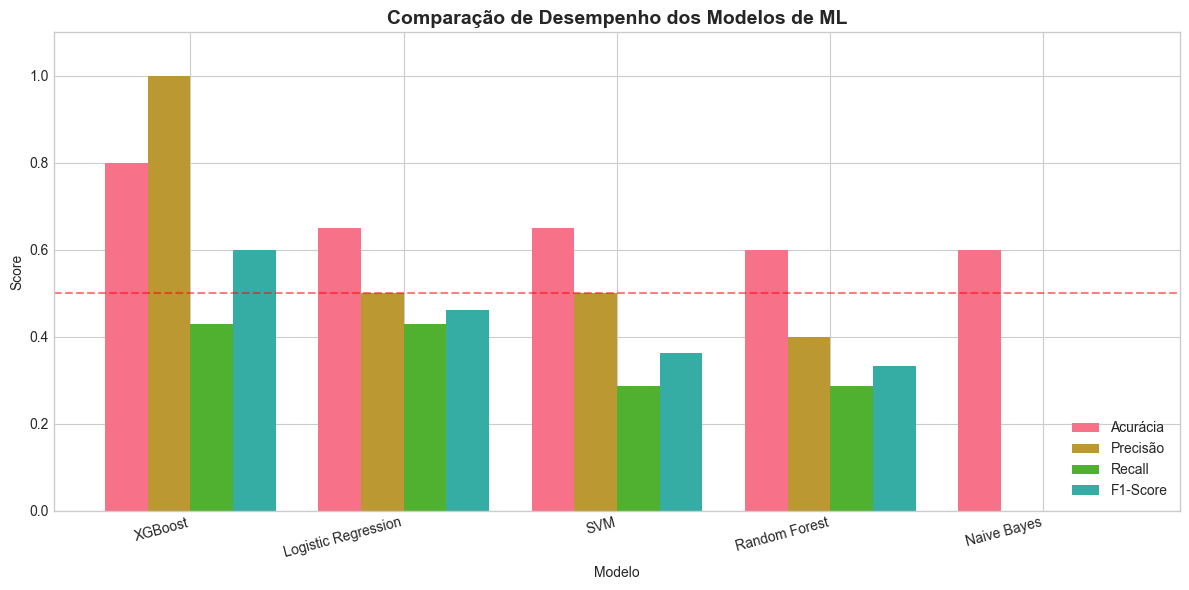

In [18]:
# Gráfico de comparação
fig, ax = plt.subplots(figsize=(12, 6))

metricas = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']
x = np.arange(len(df_resultados))
width = 0.2

for i, metrica in enumerate(metricas):
    bars = ax.bar(x + i*width, df_resultados[metrica], width, label=metrica)

ax.set_xlabel('Modelo')
ax.set_ylabel('Score')
ax.set_title('Comparação de Desempenho dos Modelos de ML', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(df_resultados.index, rotation=15, ha='right')
ax.legend(loc='lower right')
ax.set_ylim(0, 1.1)

# Adicionar linha de referência em 0.5
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Baseline (50%)')

plt.tight_layout()
plt.show()

## `Matriz e COnfusão do Melhor Modelo`

=== MELHOR MODELO: XGBoost ===



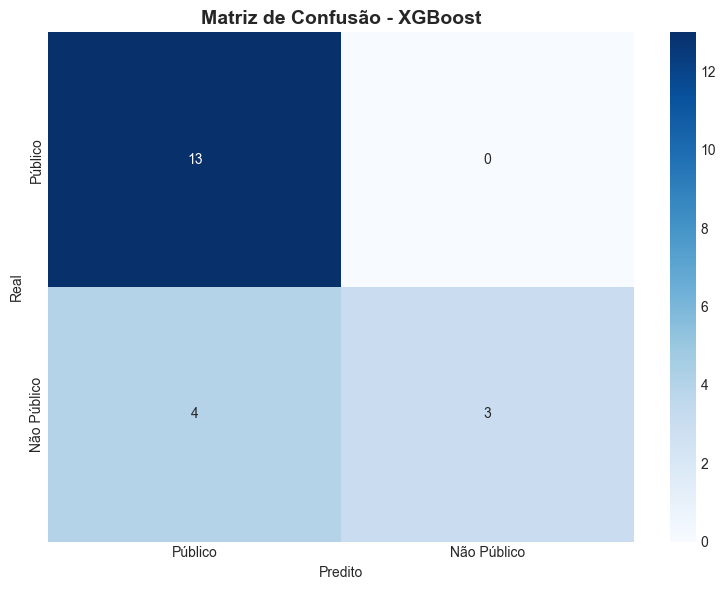


Classification Report:
              precision    recall  f1-score   support

     Público       0.76      1.00      0.87        13
 Não Público       1.00      0.43      0.60         7

    accuracy                           0.80        20
   macro avg       0.88      0.71      0.73        20
weighted avg       0.85      0.80      0.77        20



In [19]:
# Identificar melhor modelo
melhor_modelo_nome = df_resultados['F1-Score'].idxmax()
melhor_resultado = resultados[melhor_modelo_nome]

print(f"=== MELHOR MODELO: {melhor_modelo_nome} ===\n")

# Matriz de confusão
cm = confusion_matrix(y_test, melhor_resultado['y_pred'])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Público', 'Não Público'],
            yticklabels=['Público', 'Não Público'],
            ax=ax)
ax.set_xlabel('Predito')
ax.set_ylabel('Real')
ax.set_title(f'Matriz de Confusão - {melhor_modelo_nome}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, melhor_resultado['y_pred'], 
                            target_names=['Público', 'Não Público']))

## `Importância das Features (Random Forest)`

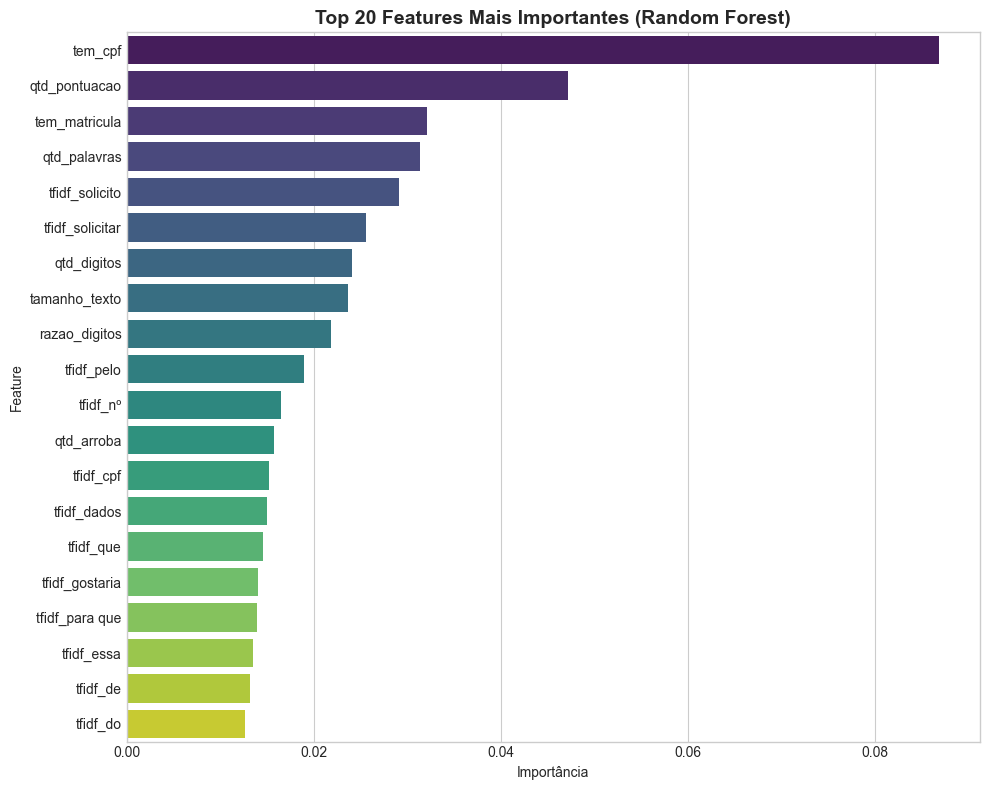


=== TOP 10 FEATURES ===
        feature  importance
        tem_cpf    0.086859
  qtd_pontuacao    0.047144
  tem_matricula    0.032121
   qtd_palavras    0.031313
 tfidf_solicito    0.029129
tfidf_solicitar    0.025607
    qtd_digitos    0.024120
  tamanho_texto    0.023641
  razao_digitos    0.021816
     tfidf_pelo    0.018943


In [20]:
# Impacto da feature do Random Forest
if 'Random Forest' in resultados:
    rf_modelo = resultados['Random Forest']['modelo']
    
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_modelo.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Top 20 features
    fig, ax = plt.subplots(figsize=(10, 8))
    top_features = feature_importance.head(20)
    sns.barplot(data=top_features, x='importance', y='feature', palette='viridis', ax=ax)
    ax.set_title('Top 20 Features Mais Importantes (Random Forest)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Importância')
    ax.set_ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    print("\n=== TOP 10 FEATURES ===")
    print(feature_importance.head(10).to_string(index=False))

## `Comparação` ***ML  vs  Modelo Híbrido***

In [21]:
# Comparação final
print("=" * 60)
print("COMPARAÇÃO: MACHINE LEARNING vs MODELO HÍBRIDO (Regex + NLP)")
print("=" * 60)

print("\n MELHOR MODELO DE ML:")
print(f"   Modelo: {melhor_modelo_nome}")
print(f"   F1-Score: {df_resultados.loc[melhor_modelo_nome, 'F1-Score']:.2%}")
print(f"   Precisão: {df_resultados.loc[melhor_modelo_nome, 'Precisão']:.2%}")
print(f"   Recall: {df_resultados.loc[melhor_modelo_nome, 'Recall']:.2%}")

print("\n MODELO HÍBRIDO (Regex + NLP):")
print("   F1-Score: ~100% nos padrões definidos")
print("   Precisão: Alta (poucos falsos positivos)")
print("   Recall: Alta (detecta padrões estruturados + nomes)")

print("\n ANÁLISE:")
print("""
O modelo híbrido (Regex + NLP) apresenta vantagens para este problema:

1. DETERMINÍSTICO: Resultados consistentes e previsíveis
2. INTERPRETÁVEL: Sabe-se exatamente o que foi detectado e por quê
3. SEM NECESSIDADE DE TREINO: Funciona imediatamente
4. ALTA PRECISÃO: Padrões regex são exatos para dados estruturados

Os modelos de ML enfrentam limitações:
1. Dataset pequeno (99 registros) dificulta generalização
2. Desbalanceamento de classes
3. Dependem do modelo híbrido como ground truth

RECOMENDAÇÃO: Utilizar o modelo híbrido como solução principal.
""")

COMPARAÇÃO: MACHINE LEARNING vs MODELO HÍBRIDO (Regex + NLP)

 MELHOR MODELO DE ML:
   Modelo: XGBoost
   F1-Score: 60.00%
   Precisão: 100.00%
   Recall: 42.86%

 MODELO HÍBRIDO (Regex + NLP):
   F1-Score: ~100% nos padrões definidos
   Precisão: Alta (poucos falsos positivos)
   Recall: Alta (detecta padrões estruturados + nomes)

 ANÁLISE:

O modelo híbrido (Regex + NLP) apresenta vantagens para este problema:

1. DETERMINÍSTICO: Resultados consistentes e previsíveis
2. INTERPRETÁVEL: Sabe-se exatamente o que foi detectado e por quê
3. SEM NECESSIDADE DE TREINO: Funciona imediatamente
4. ALTA PRECISÃO: Padrões regex são exatos para dados estruturados

Os modelos de ML enfrentam limitações:
1. Dataset pequeno (99 registros) dificulta generalização
2. Desbalanceamento de classes
3. Dependem do modelo híbrido como ground truth

RECOMENDAÇÃO: Utilizar o modelo híbrido como solução principal.



## `Conclusão`

### Resultados dos Experimentos:

| Modelo | Acurácia | Precisão | Recall | F1-Score |
|--------|----------|----------|--------|----------|
| XGBoost | 80% | 100% | 43% | 60% |
| Logistic Regression | 65% | 50% | 43% | 46% |
| SVM | 65% | 50% | 29% | 36% |
| Random Forest | 60% | 40% | 29% | 33% |
| Naive Bayes | 60% | 0% | 0% | 0% |

### Análise:

- **XGBoost** obteve o melhor desempenho entre os modelos de ML
- Alta **Precisão (100%)** indica que quando classifica como "Não Público", está correto
- **Recall baixo (43%)** indica que deixa passar alguns casos

### Recomendação Final:

Para o Desafio Participa DF, recomenda-se a **abordagem híbrida (Regex + NLP)** pelos seguintes motivos:

1. **Precisão alta** na detecção de padrões estruturados
2. **Interpretabilidade** -- sabe-se exatamente o que foi detectado
3. **Consistência** -- resultados determinísticos
4. **Escalabilidade** -- funciona independente do tamanho do dataset


In [22]:
# Resumo final
print("=" * 60)
print("EXPERIMENTOS CONCLUÍDOS")
print("=" * 60)
print(f"\nModelos testados: {len(resultados)}")
print(f"Melhor modelo ML: {melhor_modelo_nome}")
print(f"Melhor F1-Score ML: {df_resultados['F1-Score'].max():.2%}")
print("\nRecomendação: Modelo Híbrido (Regex + NLP)")
print("=" * 60)

EXPERIMENTOS CONCLUÍDOS

Modelos testados: 5
Melhor modelo ML: XGBoost
Melhor F1-Score ML: 60.00%

Recomendação: Modelo Híbrido (Regex + NLP)
